In [1]:
import numpy as np
from abc import ABC, abstractmethod
from sklearn.tree import DecisionTreeClassifier   # for Task 4
import matplotlib.pyplot as plt                   # for Task 5
from sklearn.metrics.pairwise import rbf_kernel   # for Task 6

In [2]:
class MAB(ABC):
    """Base class for a contextual multi-armed bandit (MAB)
    
    Parameters
    ----------
    n_arms : int
        Number of arms.
    """
    def __init__(self, n_arms):
        if not np.issubdtype(type(n_arms), np.integer):
            raise TypeError("`n_arms` must be an integer")
        if not n_arms >= 0:
            raise ValueError("`n_arms` must be non-negative")
        self.n_arms = n_arms
        # your code here (if you like)
        
    @abstractmethod
    def play(self, context):
        """Play a round
        
        Parameters
        ----------        
        context : float numpy.ndarray, shape (n_arms, n_dims), optional
            An array of context vectors presented to the MAB. The 0-th 
            axis indexes the arms, and the 1-st axis indexes the features.
            Non-contextual bandits accept a context of None.
        
        Returns
        -------
        arm : int
            Integer index of the arm played this round. Should be in the set 
            {0, ..., n_arms - 1}.
        """
        # your code here (if you like)
    
    @abstractmethod
    def update(self, arm, reward, context):
        """Update the internal state of the MAB after a play
        
        Parameters
        ----------
        arm : int
            Integer index of the played arm in the set {0, ..., n_arms - 1}.
        
        reward : float
            Reward received from the arm.
        
        context : float numpy.ndarray, shape (n_arms, n_dims), optional
            An array of context vectors that was presented to the MAB. The 
            0-th axis indexes the arms, and the 1-st axis indexes the 
            features. Non-contextual bandits accept a context of None. 
        """
        # your code here (if you like)

## 1. Implement ε-greedy and UCB MABs

In [3]:
class EpsGreedy(MAB):
    """Epsilon-Greedy multi-armed bandit

    Parameters
    ----------
    n_arms : int
        Number of arms

    epsilon : float
        Explore probability. Must be in the interval [0, 1].

    Q0 : float, default=np.inf
        Initial value for the arms.
    """
    def __init__(self, n_arms, epsilon, Q0=np.inf):
        super().__init__(n_arms)
        self.n_arms = n_arms
        self.epsilon = epsilon
        self.Q0 = Q0
        self.Q = np.full(n_arms, Q0)  # Initialise the reward for with Q0 value
        self.pulls_counts  = [1 for col in range(self.n_arms)]   # number of times an arm is pulled
        self.total_rewards = [Q0 for col in range(self.n_arms)] # the total rewards observed from each arm
         
    def play(self, context=None):
        super().play(context)
        if np.random.random() < self.epsilon:
            chosen_arm = np.random.randint(self.n_arms)#(Exloration mode)
        else:
            #To break ties: select randomly the chosen arm from the best ones
            chosen_arm = np.random.choice((np.argwhere(self.Q == np.amax(self.Q)).flatten().tolist()))# (Exploitation mode)
        return chosen_arm + 1 # we add one to the cohen arm as the array index starts at 0 and the arm action has to be at least one
        
        
    def update(self, arm, reward, context=None):
        super().update(arm, reward, context)
        arm_indx = arm - 1  # we substract 1 since the array index starts with 0 
        self.pulls_counts [arm_indx] += 1
        counter = self.pulls_counts [arm_indx]
        if self.Q[arm_indx] == self.Q0: 
            v = 0                    
        else:
            v = self.Q[arm_indx] #getting the former values of an arm 
        self.Q[arm_indx] = self.total_rewards[arm_indx] / float(counter)

In [4]:
class UCB(MAB):
    """Upper Confidence Bound (UCB) multi-armed bandit

    Parameters
    ----------
    n_arms : int
        Number of arms.

    rho : float
        Positive real explore-exploit parameter.

    Q0 : float, default=np.inf
        Initial value for the arms.
    """
    def __init__(self, n_arms, rho, Q0=np.inf):
        super().__init__(n_arms)
        self.n_arms = n_arms
        self.Q = np.full(n_arms, Q0)
        self.Q0 = Q0
        self.pulls_counts = [1 for col in range(self.n_arms)] #Stores the count of an arm is pulled
        self.total_rewards = [Q0 for col in range(self.n_arms)] # Sotres the total number of observed rewards 
        self.rho = rho  # Exploration hyperparameter
        self.Mu = np.zeros(n_arms)  # Stores the average reward per arm that used to calculate the Q value
        self.t_round = 1 # to count the rounds
        
        
    
    def play(self, context=None):
        super().play(context)
        # Calculate Q value of an arm, which is the expected reward, with log of the current t_round
        # then choose (play) the one with the best value
        for arm in range(self.n_arms):
            counter = self.pulls_counts[arm] #to count how many time an arm is pulled
            if counter > 0 :  
                self.Q[arm] = self.Mu[arm] + np.sqrt(self.rho * np.log(self.t_round) / float(counter)) 
            else:
                self.Q[arm] = self.Q0  #if an arm has not plulled yet
                
        #To break ties: select randomly the chosen arm from the best ones
        chosen_arm = np.random.choice((np.argwhere(self.Q == np.amax(self.Q)).flatten().tolist())) 
        
        return chosen_arm + 1 
        
    def update(self, arm, reward, context=None):
        super().update(arm, reward, context)
        
        arm_indix = arm - 1
        self.total_rewards[arm_indix] += reward
        self.pulls_counts[arm_indix] += 1
        self.t_round += 1 #update an arm each time by 1
        
        counter = self.pulls_counts[arm_indix]
        # update Mu based on the total rewards we got
        if counter > 0:     #number of pulled arm must be greater than 0
            self.Mu[arm_indix] = self.total_rewards[arm_indix] / float(counter)

## 2. Implement off-policy evaluation

In [5]:
def offlineEvaluate(mab, arms, rewards, contexts, n_rounds=None):
    """Offline evaluation of a multi-armed bandit
    
    Parameters
    ----------
    mab : instance of MAB
        MAB to evaluate.
    
    arms : integer numpy.ndarray, shape (n_events,) 
        Array containing the history of pulled arms, represented as integer 
        indices in the set {0, ..., mab.n_arms}
    
    rewards : float numpy.ndarray, shape (n_events,)
        Array containing the history of rewards.
    
    contexts : float numpy.ndarray, shape (n_events, n_arms, n_dims)
        Array containing the history of contexts presented to the arms. 
        The 0-th axis indexes the events in the history, the 1-st axis 
        indexes the arms and the 2-nd axis indexed the features.
        
    n_rounds : int, default=None
        Number of matching events to evaluate the MAB on. If None, 
        continue evaluating until the historical events are exhausted.
    
    Returns
    -------
    out : float numpy.ndarray
        Rewards for the matching events.
    """
    t_round = 0 #initialise t round per play with 0
    out = []  # an empty initial total payoffs
       

    #len(arms)reperents the number of logged events since arms : integer numpy.ndarray, shape (n_events,) 
    for event in range(len(arms)): #stepping through the stream of logged events  
        if t_round >= n_rounds:
            break
            
        if n_rounds is None:
            n_rounds = len(arms) #If n_rounds is None, continue evaluating until the historical events are exhausted
            
        logged_arm = int(arms[event])
       
        reward = rewards[event]
        context = contexts[event]
        chosen_arm = int(mab.play(context))
                     
        #if a chosen arm by a mab matches the logged arm, t_round is incremented and mab bandit is updated with 
        #the chosen arm, rewards and context
        if chosen_arm == logged_arm:
            mab.update(chosen_arm , reward, context)
            out.append(reward)  #append the reward to the rewards for the matching events
            t_round += 1 
 
             
    return out

In [6]:
# load dataset here
# load dataset here
data = open("dataset.txt", "r") 
dataset = np.loadtxt(data, dtype = int)
arms = dataset[:,0]  #Column 1 (The arm played)
rewards = dataset[:,1]  #Column 2 (The reward received from the arm played)
contexts = dataset[:,2:]  #Column 3:102 (The 100-dim flattened context)

In [7]:
mab = EpsGreedy(10, 0.05)
results_EpsGreedy = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('EpsGreedy average reward', np.mean(results_EpsGreedy))

EpsGreedy average reward 0.125


In [8]:
mab = UCB(10, 1.0)
results_UCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('UCB average reward', np.mean(results_UCB))

UCB average reward 0.14625


## 3. Implement LinUCB contextual MAB

In [9]:
class LinUCB(MAB):
    """Contextual multi-armed bandit (LinUCB)

    Parameters
    ----------
    n_arms : int
        Number of arms.

    n_dims : int
        Number of features for each arm's context.

    alpha : float
        Positive real explore-exploit parameter.
    """
    def __init__(self, n_arms, n_dims, alpha):
        super().__init__(n_arms)
        # Fetches  no of  contexts
        self.n_arms = n_arms
        self.n_dims = n_dims
        self.alpha = alpha
        self.A = [np.identity(n_dims,dtype=np.int) for a in range(n_arms)]  # define A as identity matrix
        self.b = [np.zeros((n_dims,1),dtype=np.int) for a in range(n_arms)]  # define b as a response vector b
        self.p_t = np.zeros((self.n_arms))  # Stores expected payoff of each arm  
        
    
    def play(self, context):
        super().play(context)
    
        for arm in range(self.n_arms):
            
            #x =  np.reshape(context, (self.n_arms,self.n_dims))[arm].reshape((self.n_dims, 1))
            x = np.reshape(context,(self.n_arms,self.n_dims))[arm:arm+1,:].T
           
            try: 
                A_inv = np.linalg.inv(self.A[arm]) #take the inverse of A as coverience for 
            except np.linalg.LinAlgError:
                pass
            else:
                theta = np.dot(A_inv, self.b[arm]) # Calculate ridge regression on the ovto estimate the coefficient vectore
            
            #Get the expected payoff of an arm by theta and standard deviation    
            self.p_t[arm] = np.dot(theta.T, x) + self.alpha * (np.sqrt((np.dot(x.T , np.dot(A_inv, x)))))
                    
        #To break ties: select randomly the chose arm from the best ones
        chosen_arm = np.random.choice(np.argwhere(self.p_t == np.amax(self.p_t)).flatten().tolist())
        
        return chosen_arm + 1
       
    def update(self, arm, reward, context):
        super().update(arm, reward, context)
        arm_index = arm - 1
        #update with the rewards we got
        x = np.reshape(context,(self.n_arms,self.n_dims))[arm:arm+1,:].T
        self.A[arm_index] += np.dot(x, x.T)
        self.b[arm_index] += reward * x
        

In [10]:
mab = LinUCB(10, 10, 1.0)
results_LinUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('LinUCB average reward', np.mean(results_LinUCB))

LinUCB average reward 0.31625


## 4. Implement TreeBootstrap contextual MAB

In [11]:
class TreeBootstrap(MAB):
    """Contextual Thompson sampled multi-armed bandit (TreeBootstrap)

    Parameters
    ----------
    n_arms : int
        Number of arms.

    n_dims : int
        Number of features for each arm's context.

    tree : instance of sklearn.tree.DecisionTreeClassifier, optional
        Decision tree to use for predicting the expected future reward. 
        Defaults to sklearn.tree.DecisionTreeClassifier().
    """
    def __init__(self, n_arms, n_dims, tree=DecisionTreeClassifier()):
        super().__init__(n_arms)
        self.n_dims = n_dims
        self.tree = tree
        # Initialise a tuple of our dataset to store context-rewards pairs
        self.D = [np.array(()) for a in range(n_arms)]
        #Stores the object of decision tree θ
        self.theta = np.zeros((n_arms)) 
        #Stores the estimated probability of success from using decision tree θ on contexts
        self.phat = np.zeros((n_arms))
       
    def play(self, context):
        super().play(context)
        for arm in range(self.n_arms):
            if len(self.D[arm]) == 0: 
                self.phat[arm] = 1.0 # if len of D <= 0
            else:
                #create bootstrapped datasets, each one formed by sampling context-reward pairs from Dt,a with replacement
                bootstrapped_Dt = self.D[arm][np.random.choice(len(self.D[arm]), len(self.D[arm]))] 
                # fit the decision tree classfier to contexts-pairs, as training data
                # Thompson sample is then a randomly selected tree from this collection.
                theta = self.tree.fit(bootstrapped_Dt[:,0].reshape(-1, 1), bootstrapped_Dt[:,-1])     
                # predict the estimated probability on context of the current arm, as test data of the classfier 
                self.phat[arm] = theta.predict_proba(context[arm].reshape(1, -1)).flatten()[-1]
    
        chosen_arm = np.random.choice(np.argwhere(self.phat == np.amax(self.phat)).flatten().tolist())
        
        return chosen_arm + 1

    def update(self, arm, reward, context):
        super().update(arm, reward, context)
        if len(self.D[arm]) == 0:
            #Adding fabricated prior dataset of one success and one failure for each arm when it is first pulled
            self.D[arm] = np.array([[context[arm],0]])
            #Update the dataset with contexts and reward of the arm 
            self.D[arm] = np.concatenate([self.D[arm], np.array([[context[arm],1]])], 0)
        self.D[arm] = np.concatenate([self.D[arm], np.array([[context[arm], reward]])], 0) #update D with the pulled arm reward

In [12]:
mab = TreeBootstrap(10, 10)
results_TreeBootstrap = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('TreeBootstrap average reward', np.mean(results_TreeBootstrap))

TreeBootstrap average reward 0.19875


## 5. Evaluation and hyperparameter tuning for LinUCB
### 5.A.

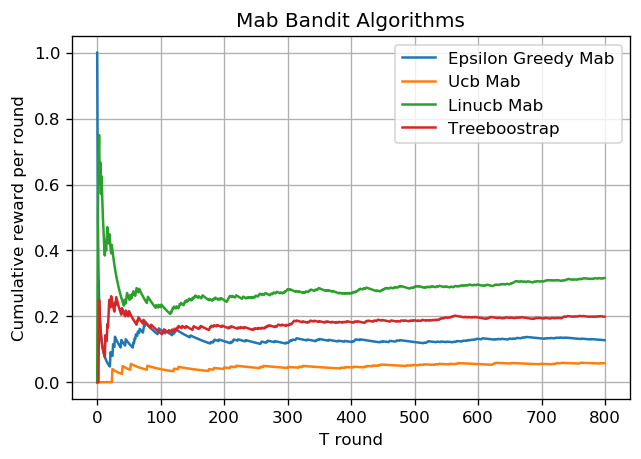

In [13]:
def plot_function(mab_offlineEvaluate): 
    t_rounds = 800
    plt.subplots(dpi=120)
    for mab, results in mab_offlineEvaluate:
        p = plt.plot(range(len(results))
                       , list(map(lambda x:x[0]/x[1], zip(np.cumsum(results), np.arange(t_rounds)+1)))
                       , label=mab.title())
    plt.grid()
    plt.title("Mab Bandit Algorithms")
    plt.xlabel("T round")
    plt.ylabel("Cumulative reward per round")
    plt.legend()
    plt.show()


mab = EpsGreedy(10, 0.05)
results_EpsGreedy = offlineEvaluate(mab, arms, rewards, contexts, 800)

mab = UCB(10, 1.0)
results_UCB = offlineEvaluate(mab, arms, rewards, contexts, 800)

mab = LinUCB(10, 10, 1.0)
results_LinUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)

#mab = TreeBootstrap(10, 10)
#results_TreeBootstrap = offlineEvaluate(mab, arms, rewards, contexts, 800)

plot_function([('Epsilon Greedy Mab', results_EpsGreedy),('UCB Mab', results_UCB), 
               ('LinUCB Mab', results_LinUCB),('TreeBoostrap', results_TreeBootstrap)])

### 5.B.

The best value for alpha is: 0.5263157894736842


<Figure size 432x288 with 0 Axes>

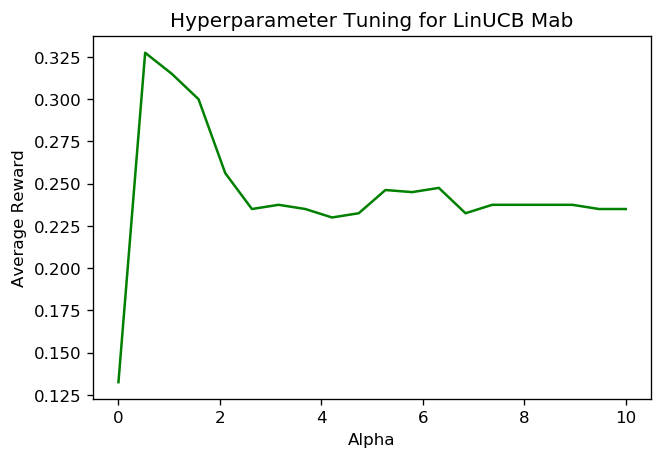

The best value for alpha is: 1.52


<Figure size 432x288 with 0 Axes>

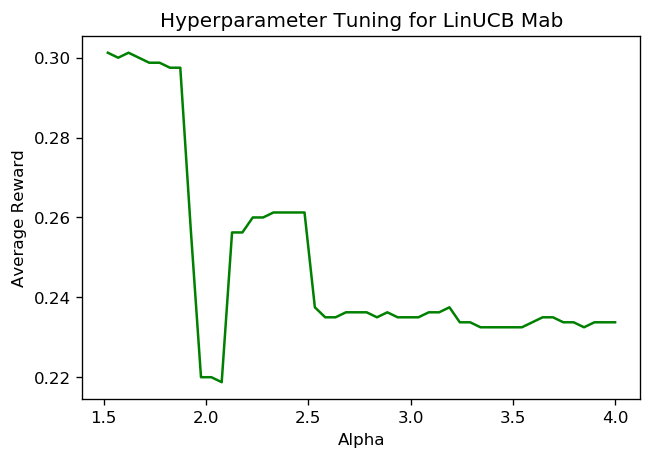

In [14]:
# grid search function to search exhaustively and gridly for best hyperparameter(alpha) in LinUCB Mab 
def gridsearch_alpha(alpha_min, alpha_max, val):
    grid_alpha= []
  
    for alpha in np.linspace(alpha_min, alpha_max, val):
        mab = LinUCB(10, 10, alpha)
        rewards_per_alpha = offlineEvaluate(mab, arms, rewards, contexts, 800)# use offline policy of linUCB mab to caluclate the reward for each chosen alpha 
        grid_alpha.append(np.mean(rewards_per_alpha)) # take the average reward per alpha    
     
    best_val = np.argmax(grid_alpha) # choose the best alpha corresponding to the best average reward
    best_alpha = np.linspace(alpha_min, alpha_max, val)[best_val]    
    print('The best value for alpha is: ' + str(best_alpha))
    
    plt.figure()
    plt.subplots(dpi=120)
    ax = plt.axes()
    ax.plot(np.linspace(alpha_min, alpha_max, val), grid_alpha, 'g')
    plt.title("Hyperparameter Tuning for LinUCB Mab")
    plt.xlabel("Alpha")
    plt.ylabel("Average Reward")
    plt.show()

    
###### Call the grid function and try it on two different ranges, following the LinUCB paper  #####
# set poisitve range for alpha > 0, as this is the general range in practice
gridsearch_alpha(0, 10, 20)

# Set alpha >  1.5 as suggested in the paper for optimization 
gridsearch_alpha(1.52, 4, 50)

## 6. Implement KernelUCB contextual MAB

In [15]:
class KernelUCB(MAB):
    """Kernelised contextual multi-armed bandit (Kernelised LinUCB)
    
    Parameters
    ----------
    n_arms : int
        Number of arms.

    n_dims : int
        Number of features for each arm's context.

    gamma : float
        Positive real explore-exploit parameter.
    
    eta : float
        Positive real explore-exploit parameter.
    
    kern : callable
        A kernel function from sklearn.metrics.pairwise.
    """
    
    def __init__(self, n_arms, n_dims, gamma, eta, kern):
        super().__init__(n_arms)     
        self.n_arms = n_arms
        self.n_dims = n_dims
        self.gamma = gamma
        self.eta = eta
        self.kern = kern
        self.inv_Kt = np.zeros(0) #Storee kernel matrix inverse for each tround
        self.rewards_history = np.zeros(0 ,dtype = int) #Stores the history of the coming rewards so far
        self.contexts_history = np.zeros((0, n_dims)) #Stores the history of the coming contexts so far
        self.u_t = np.zeros(self.n_arms) 
        self.t_round = 0 #Initialise the round of pulling arms with 0
        

    def play(self, context):
        super().play(context)
       
        if self.t_round  <= 1:   
            self.u_t[0] = 1
        else:
             for arm in range(self.n_arms):
                    #observe the received contexts and reshape it 
                    x_t = context.reshape((self.n_arms, -1))
                    # estimator invloves only the kernel between contexts vectors
                    k_xxt = self.kern(x_t[arm].reshape(-1,1), x_t[arm].reshape(-1,1)).diagonal()
                    # evaluate the kernel between arm context and the history of all the contexts of pulled arms so far
                    k_xt = self.kern(x_t, self.contexts_history)
                    #Calculate sigma to construct the widths of the confidence intervals around the prediction
                    sigma = np.sqrt(k_xxt - np.sum(k_xt[arm].T * np.dot(self.inv_Kt, k_xt[arm].T), axis=0))
                    self.u_t[arm] = np.dot(k_xt[arm], np.dot(self.inv_Kt, self.rewards_history)) + self.eta/(np.sqrt(self.gamma)) * sigma[arm]
             
            
        #Choose the arm with maximum u_t value
        #To break ties: select randomly the chose arm from the best ones
        chosen_arm = np.random.choice((np.argwhere(self.u_t == np.amax(self.u_t)).flatten()))
        
        return chosen_arm 
              
    
    def update(self, arm, reward, context):
        super().update(arm, reward, context)
        #observe the received contexts and reshape it 
        x_t = context.reshape((self.n_arms, -1))
        
        # Update the contexts and rewards histories as well as the played t round
        self.rewards_history = np.append(self.rewards_history, reward)
        self.contexts_history = np.append(self.contexts_history, x_t[arm, np.newaxis], axis=0)
        self.t_round = len(self.contexts_history)
        
        #evaluate the kernel between arm context and the history of all the contexts of pulled arms so far
        k_xt = self.kern(x_t, self.contexts_history)
        if self.t_round  == 1:
            # Initialise kernel matrix inverse when arm first pulled
            self.inv_Kt = 1/(k_xt[arm, np.newaxis] + self.gamma)
        else:
            # Update iteratively the kernel matrix by first constructing submatrices, and then merging them together
            b = k_xt[arm,0:-1]
            K22 = 1/(k_xt[arm,-1] + self.gamma - np.dot(b.T, np.dot(b, self.inv_Kt)))
            K11 =  self.inv_Kt + K22 * np.outer(np.dot(b, self.inv_Kt), np.dot(b.T, self.inv_Kt))
            K12 = -K22 * np.dot(b, self.inv_Kt)[:,np.newaxis]
            K21 = -K22 * np.dot(b, self.inv_Kt)[np.newaxis]
            self.inv_Kt = np.block([[K11, K12], [K21, K22]])
            #print(self.inv_Kt.shape)

In [16]:
mab = KernelUCB(10, 10, 1.0, 0.1, rbf_kernel)
results_KernelUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('KernelUCB average reward', np.mean(results_KernelUCB))

KernelUCB average reward 0.73875


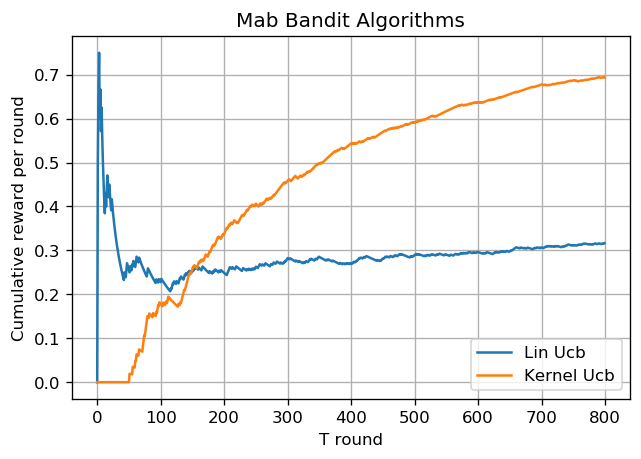

In [17]:
# A plot demonstrates competitive performance relative to LinUCB
def plot_function(mab_offlineEvaluate): 
    t_rounds = 800
    plt.subplots(dpi=120)
    for mab, results in mab_offlineEvaluate:
        p = plt.plot(range(len(results))
                       , list(map(lambda x:x[0]/x[1], zip(np.cumsum(results), np.arange(t_rounds)+1)))
                       , label=mab.title())
    plt.grid()
    plt.title("Mab Bandit Algorithms")
    plt.xlabel("T round")
    plt.ylabel("Cumulative reward per round")
    plt.legend()
    plt.show()

mab = LinUCB(10, 10, 1.0)
results_LinUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)

mab = KernelUCB(10, 10, 1.0, 0.1, rbf_kernel)
results_KernelUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)


plot_function([('Lin UCB', results_LinUCB),('Kernel UCB', results_KernelUCB)])